In [41]:
import pydicom
# import SimpleITK as sitk
import pandas as pd 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import cv2
import tensorflow as tf
from pathlib import Path
import pathlib
# %matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

In [18]:
path = Path("data/content/")

In [19]:
df = pd.read_csv(path / "labels.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head(100)

,SOPInstanceUID,Label
0,1.2.246.512.1002.1058214001.1267878993.1650415...,normal
1,2.25.4669378111734520225376815262123197003,normal
2,1.2.246.512.1.2.0.4.397070732735579.1755416012...,normal
3,2.25.253986991488355213316410237483051286906,normal
4,2.25.61269522713157549205486841880699641492,normal
...,...,...
95,2.25.95301085161359068904812759023575525475,abnormal
96,1.2.246.512.1.2.0.4.120699027219781.1785915121...,normal
97,2.25.40752906400399014196156034336759107300,normal
98,1.2.246.512.1002.3876311061.1152214383.7426756...,normal


In [20]:
len(df.loc[df['Label'] == "abnormal"])

49

In [21]:
import numpy as np
from skimage import io, filters, color, feature, exposure

In [22]:
images, labels = list(), list()
for idx, (sop, lbl) in df.head(10).iterrows():
    ds = pydicom.dcmread(path / f"DICOM/{sop}.dcm")
    img = ds.pixel_array.astype(float)
    cropped = img[200:1300 , 500:2700]
    
    # Apply normalization
    cropped_norm = exposure.rescale_intensity(cropped, in_range='image', out_range=(0, 255))
    
    images.append(cropped_norm)
    labels.append(1 if lbl == "abnormal" else 0)

In [23]:
# Define Gabor filter parameters
ksize = 31
sigma = 5
theta = 0
lamda = 10
gamma = 0.5
psi = 0
def apply_gabor_filter(img):    
    # Apply Gabor filter
    filt_real, filt_imag = filters.gabor(img, frequency=1/lamda, 
                                                 theta=theta, sigma_x=sigma, 
                                                 sigma_y=sigma/gamma, n_stds=3)
    
    # Calculate magnitude of the filtered image
    filt_mag = np.sqrt(filt_real**2 + filt_imag**2)
    
    # Normalize filtered image
    filt_mag = (filt_mag - filt_mag.min()) / (filt_mag.max() - filt_mag.min())
    
    # Convert filtered image to 8-bit integer
    filt_mag = (filt_mag * 255).astype(np.uint8)

In [24]:
gabor_images = []
for img in images:
    gabor_img = apply_gabor_filter(img)
    gabor_images.append(gabor_img)


In [33]:
from skimage import io, exposure, data


In [34]:
sobel_images = []
for img in images:
    sobel_images.append(filters.gaussian(img))


In [35]:
filtered_images = []
for img in images:
    exposured_image = exposure.adjust_gamma(img, gamma=0.8)
    filtered_images.append(filters.gaussian(exposured_image))
    

In [36]:
new_images = filtered_images

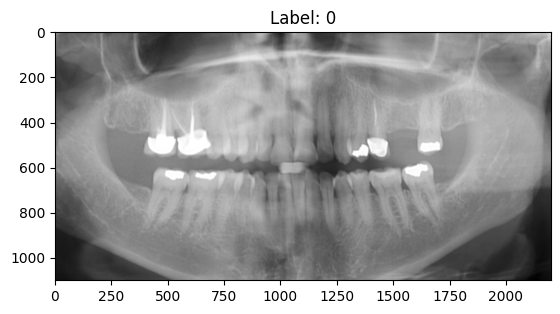

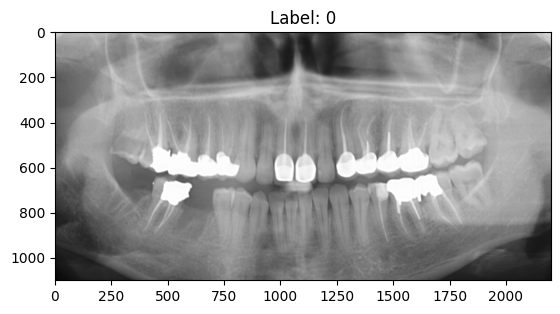

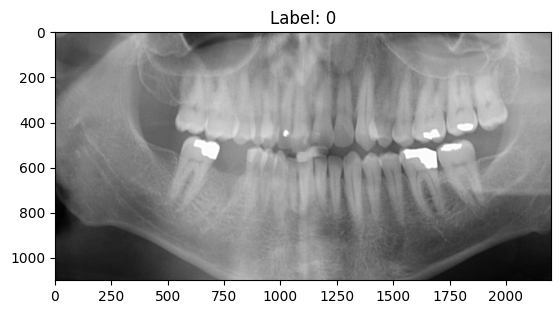

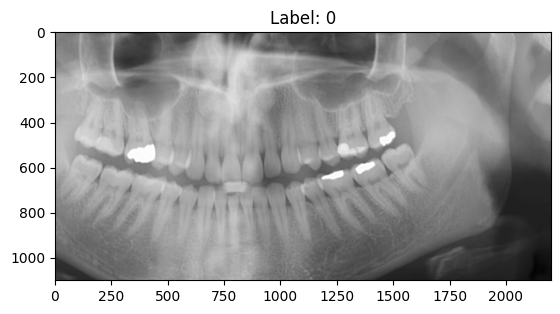

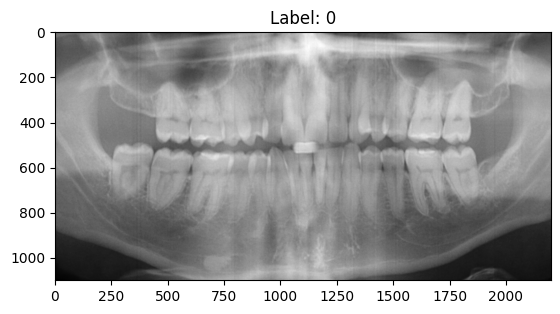

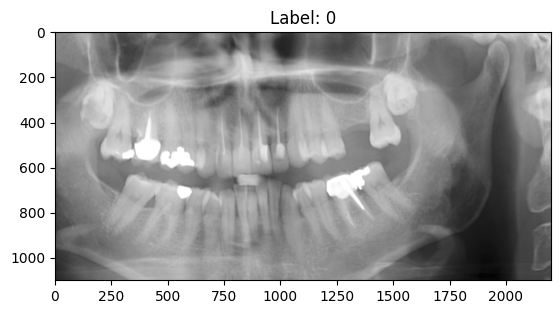

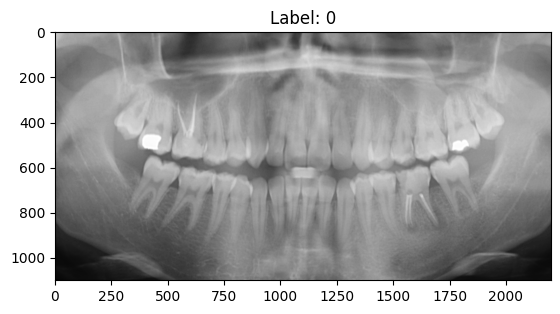

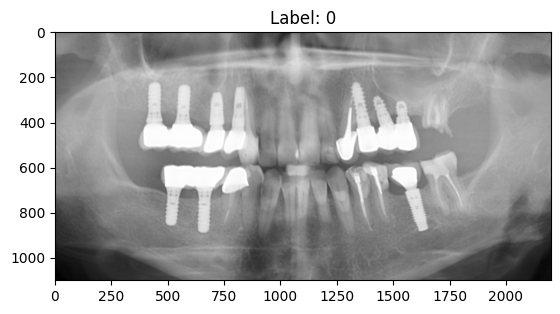

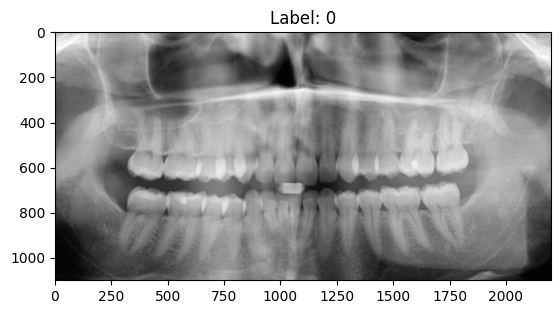

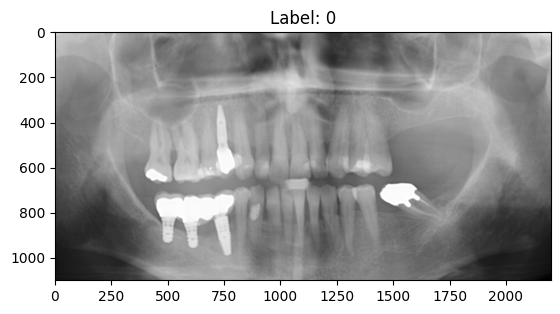

In [37]:
for i in range(len(new_images)):
    plt.imshow(new_images[i], cmap=plt.cm.gray)
    plt.title(f"Label: {labels[i]}")
    plt.show()

In [38]:
images = np.array(images)
labels = np.array(labels)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)

In [40]:
inputs = tf.keras.layers.Input(shape=(224, 224, 1))
x = tf.keras.layers.Conv2D(3, 1, 1, padding='same')(inputs)
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

NameError: name 'tf' is not defined

In [ ]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc', tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),])

In [ ]:
res = model.fit(x=X_train, y=y_train, epochs=10, validation_split=0.3, batch_size=2)

2023-05-21 14:20:45.847074: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 4910400000 exceeds 10% of free system memory.
2023-05-21 14:22:24.567233: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 3427200000 exceeds 10% of free system memory.
2023-05-21 14:22:57.811000: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 4910400000 exceeds 10% of free system memory.
2023-05-21 14:23:03.907568: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 1483200000 exceeds 10% of free system memory.


Epoch 1/10


2023-05-21 14:23:16.672200: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 230400000 exceeds 10% of free system memory.


: 

: 

In [ ]:
model.save("model.h5")

In [ ]:
loaded_model = tf.keras.models.load_model("model.h5")
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 3)       6         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                           

In [ ]:
loaded_model.evaluate(x=X_test, y=y_test)

6/6 [==============================] - 17s 2s/step - loss: 0.3557 - acc: 0.8929 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.5000


[0.35569828748703003, 0.8928571343421936, 0.0, 0.0, 0.5]